In [30]:
import wandb
api = wandb.Api()

# Just load seaborn & set theme and the chart looks better:
! pip install seaborn -q
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import matplotlib.colors as cor
from collections import defaultdict 
import pandas as pd
sns.set_theme()


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [31]:
_runs_pile_code = api.runs("seperability/seperability-pile-code")
_runs_code_python = api.runs("seperability/seperability-code-python")
_runs_attn = api.runs("seperability/pile-code-attn")
wandb_cache = {}

In [75]:
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10", "loss": "Loss", "perplexity": "Perplexity"}
color_map  = {"pile": "tab:orange", "code": "tab:blue", "python": "tab:green"}
dataset_map = {"pile": "Pile", "pile_codeless": "Pile", "python": "Python", "code": "Code"}
fmt_map = {
    "opt-125m": ":y",
    "opt-1.3b": "--y",
    "opt-6.7b": "-y",
    "galactica-125m": ":C2",
    "galactica-1.3b": "--C2",
    "galactica-6.7b": "-C2",
    "pythia-160m": ":C4",
    "pythia-1.4b": "--C4",
    "pythia-6.9b": "-C4",
}

def df_append(df, item: dict):
    new_data = pd.DataFrame({ k:[v] for k,v in item.items() })
    df = pd.concat([ df, new_data ], ignore_index=True )
    return df

def is_loss_metric(metric_name):
    if metric_name == "perplexity":
        return True
    if metric_name[-4:] == "loss":
        return True
    return False

def normed(h, dataset, key):
    if key == "perplexity":
        return np.exp(h[f"loss_data/{dataset}/loss"])/np.exp(h[f"loss_data/{dataset}/loss"][0])
    if is_loss_metric(key):
        return h[f"loss_data/{dataset}/{key}"]/h[f"loss_data/{dataset}/{key}"][0]
    return h[f"accuracy/{dataset}/{key}"]/h[f"accuracy/{dataset}/{key}"][0]

def calculate_area(x, y):
    return np.trapz(y, x)

def calculate_max_diff(x, y):
    x, y = np.array(x), np.array(y)
    diff = (y-x)
    return diff.max()

class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]
        
        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run
        
        self.history = self.run.history()
        self.h = self.history
        c = self.run.config
        
        self.model_name = c["model_size"].split("/")[-1].lower()
        
        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac
        
        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = dataset_map[self.cripple]
        self.focus_label   = dataset_map[self.focus]
        
        # Get "unique" names
        self.name_set = self.focus_label + " " + self.cripple_label
        self.name_set_model = self.name_set + " " + self.model_name
        
    def get_metric(self, metric, diff):
        if is_loss_metric(metric):
            return self.get_loss_metric(metric)
        if diff:
            return self.get_diag_metric(metric)
        return self.get_d_metric(metric)
    
    def get_loss_metric(self, metric):
        self.scale = 1
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale

        d_focus, d_cripple = focus_perf, cripple_perf
        #area = calculate_area(focus_perf, cripple_perf)*2 / (self.scale**2)
        score = calculate_max_diff(focus_perf, cripple_perf)
        return focus_perf, cripple_perf, score
    
    def get_diag_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        #area = ( calculate_area(d_focus, d_cripple) - self.scale**2/2 )/(self.scale**2)
        score = calculate_max_diff(d_focus, d_cripple)
        return d_cripple, d_focus, score
     
    def get_d_metric(self, metric):
        self.scale = 100
        focus_perf     = normed(self.h, self.focus,   metric) * self.scale
        cripple_perf   = normed(self.h, self.cripple, metric) * self.scale
        
        d_cripple, d_focus = self.scale-cripple_perf, self.scale-focus_perf
        #area = calculate_area(d_focus, d_cripple-d_focus)*2 / (self.scale**2)
        score = calculate_max_diff(d_focus, d_cripple)
        return d_cripple, d_focus, score

def plot_frac_pruned(run_obj, metric):
    r = run_obj
    focus_perf     = normed(r.h, r.focus,   metric)
    cripple_perf   = normed(r.h, r.cripple, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.figure()
    plt.plot(r.frac, focus_perf,   label=r.focus_label, color="tab:orange")
    plt.plot(r.frac, cripple_perf, label=r.cripple_label, color="tab:blue")
    plt.fill_between(x, focus_perf, cripple_perf, color="tab:purple", alpha=0.2)
    
    # Add details
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, None)
    plt.xlabel("Fraction of Model Pruned")
    plt.ylabel("Fraction of Original Accuracy")
    plt.title(f"{metric_name} Accuracy ({r.model_name})")
    plt.legend()
    
    cripple_area = calculate_area(r.frac, cripple_perf)
    focus_area   = calculate_area(r.frac, focus_perf)
    area_ratio = (focus_area-cripple_area)/focus_area
    print(metric_name, "%.3f" % area_ratio)
    
    return area_ratio

def plot_metric(run_obj, metric, diff=True):
    if is_loss_metric(metric):
        return plot_loss_metric(run_obj, metric, diff)
    return plot_perf_metric(run_obj, metric, diff)
    
def plot_perf_metric(run_obj, metric, diff=True): 
    r = run_obj
    d_cripple, d_focus, score = r.get_metric(metric, diff)
   
    # Plot differences in ability 
    metric_name, scale = metric_map[metric], r.scale
    plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple {r.focus_label} Focus")
    #plt.xlim(-scale*0.01, scale*1.01)
    #plt.ylim(-0.01, 1.01)
    plt.xlabel(f"Drop in {r.focus_label} Performance (%)")
    
    if diff:
        plt.ylabel(f"Differential Drop in {r.cripple_label} Performance (∆%)")
        plt.plot(d_focus, d_cripple-d_focus, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [0,     0], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [scale, 0], color="darkgray", linestyle="--", alpha=0.2)
    else:
        plt.ylabel(f"Drop in {r.cripple_label} Performance (%)")
        plt.plot(d_focus, d_cripple, fmt_map[r.model_name], label=r.model_name)
        plt.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.2)
        plt.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.2)
        
    plt.legend()
    
    return score

[(4.362463233139591, 'B Example Point'), (10.681369437035737, 'M Example Point'), (19.96548321155546, 'F Example Point'), (27.91113350870964, 'E Example Point'), (43.74207000400961, 'K Example Point'), (47.89288086177268, 'D Example Point'), (52.98052629946991, 'I Example Point'), (57.51997965238257, 'C Example Point'), (57.552686912029486, 'G Example Point'), (62.459400782806675, 'J Example Point'), (66.74830129027596, 'L Example Point'), (82.61806976291896, 'H Example Point'), (86.6574709156801, 'N Example Point'), (86.82105380221552, 'A Example Point'), (93.59091191266138, 'O Example Point')]
100


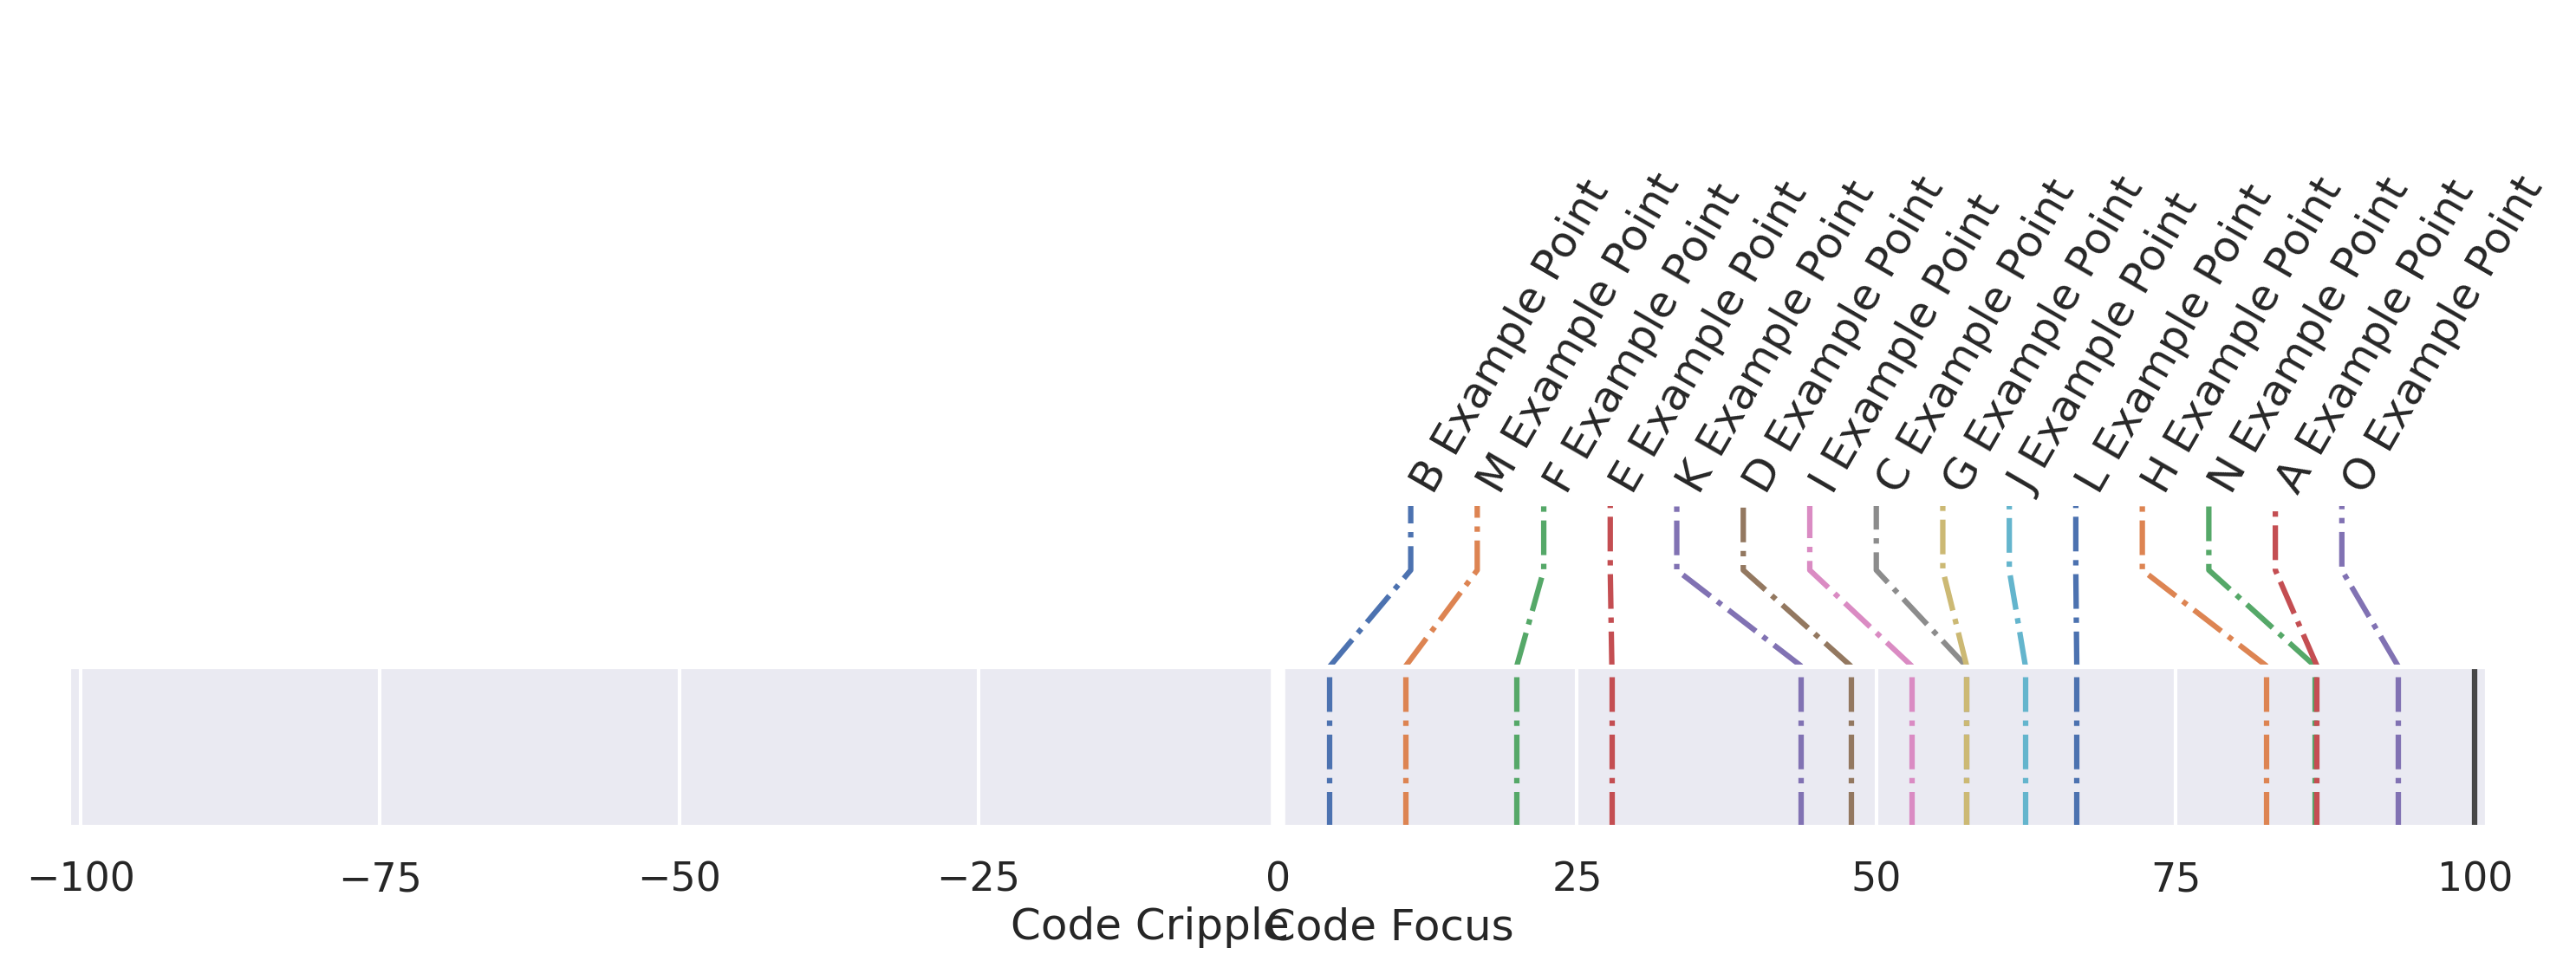

In [91]:
def plot_horizontal(_data, scale=1.0):
    # Data sort
    print(scale)
    _data.sort()
    num_points = len(_data)
    _min, _max  = min([_data[ 0][0],  0.0]), max([_data[-1][0], 1.0*scale])
    #if _min < 0.0:
    #    _min = -1*scale
    linspace = np.linspace(_min, _max, num_points+4)
    
    # Create a figure and axis
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 4),
        gridspec_kw={'height_ratios': [4, 1]}, dpi=300)
    plt.subplots_adjust(hspace=0)
    
    # Remove the y-axis and set the y-limits
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_frame_on(False)
    ax1.set_ylim(0, 1)
    ax1.vlines(0,     0, 1, color="k", linestyle="--", alpha=0.001)
    ax1.vlines(scale, 0, 1, color="k", linestyle="--", alpha=0.001)
        
    
    ax2.set_ylim(0, 1)
    ax2.get_yaxis().set_visible(False)
    ax2.vlines(0,     0, 1, color="w", linestyle="-", linewidth=4)
    ax2.vlines(scale, 0, 1, color="k", linestyle="-", alpha=0.8)
    
    # Plot the points on the number line
    for index, (point, label) in enumerate(_data):
        # Default
        linestyle = "-."
        color = None 
        fontweight = "normal"
        fontstyle = "normal"
        
        if "ff" in label:
            linestyle = "-"
        elif "attn h" in label:
            linestyle = ":"
        elif "attn" in label:
            linestyle = "--"
           
        if "random" in label:
            fontweight = "bold"
            color = "k"
            
        if "rev" in label:
            fontstyle = "italic"
       
        x_label = linspace[index+2] 
        ax1.plot([point, x_label, x_label], [0, 0.15, 0.25], linestyle=linestyle, color=color)
        ax1.text(x_label-0.005*scale, 0.26, label, rotation=60, ha='left', va='bottom',
                 fontstyle=fontstyle, fontsize=12, fontweight=fontweight)
        
        ax2.plot([point, point], [0, 1], linestyle=linestyle, color=color)
 
    return fig, (ax1, ax2)

def plot_technique_comparison(runs_filtered, scale=1.0, **kwargs):   
    df = pd.DataFrame()
    already_seen = set()
    for run in runs_filtered:
        r = WandbRunData(run)
        x = 1-normed(r.h, r.cripple, "topk_skip")
        y = 1-normed(r.h, r.focus,   "topk_skip")
        x = np.array([*x, 1])
        y = np.array([*y, 1])
        #area =  1 - calculate_area(x, y)*2
        score = np.array(calculate_max_diff(y, x))
        name = r.run.name.lower()
        name = name.split("gal 1.3b")[-1]
        name = name.split("pythia 1.4b")[-1]
        name = name.split("pc opt 1.3b")[-1]
        
        if "attn h" in name:
            h_type = "attn head " + r.run.config["attn_prune_heads"]
            name = h_type.join( name.split("attn h") )
        if "rev" in name:
            score *= -1
        
        if name in already_seen:
            continue
        already_seen.add(name) 
        new_data = { "name": name, "score": score }
        df = df_append(df, new_data)
    #    plt.plot([0, 1], [1, area], label = r.run.name)
    df = df.sort_values(by="score", ascending=False)
    l = len(df)
   
    data = [ (row["score"]*scale, row["name"]) for _i, row in df.iterrows() ]

    return plot_horizontal(data, scale, **kwargs)
    
scale = 100
points = np.random.random(15) * 100
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']
labels = [x + " Example Point" for x in labels]
data = list(zip(points, labels))
data.sort()
print(data)

fig, (ax1, ax2) = plot_horizontal(data, scale)
ax1.set_xlim(-1.01*scale, 1.01*scale)
ax2.set_xlim(-1.01*scale, 1.01*scale)
ax2.text(-1, -0.5, "Code Focus",   ha="left",  va="top")
ax2.text( 1, -0.5, "Code Cripple", ha="right", va="top")
plt.show()

100


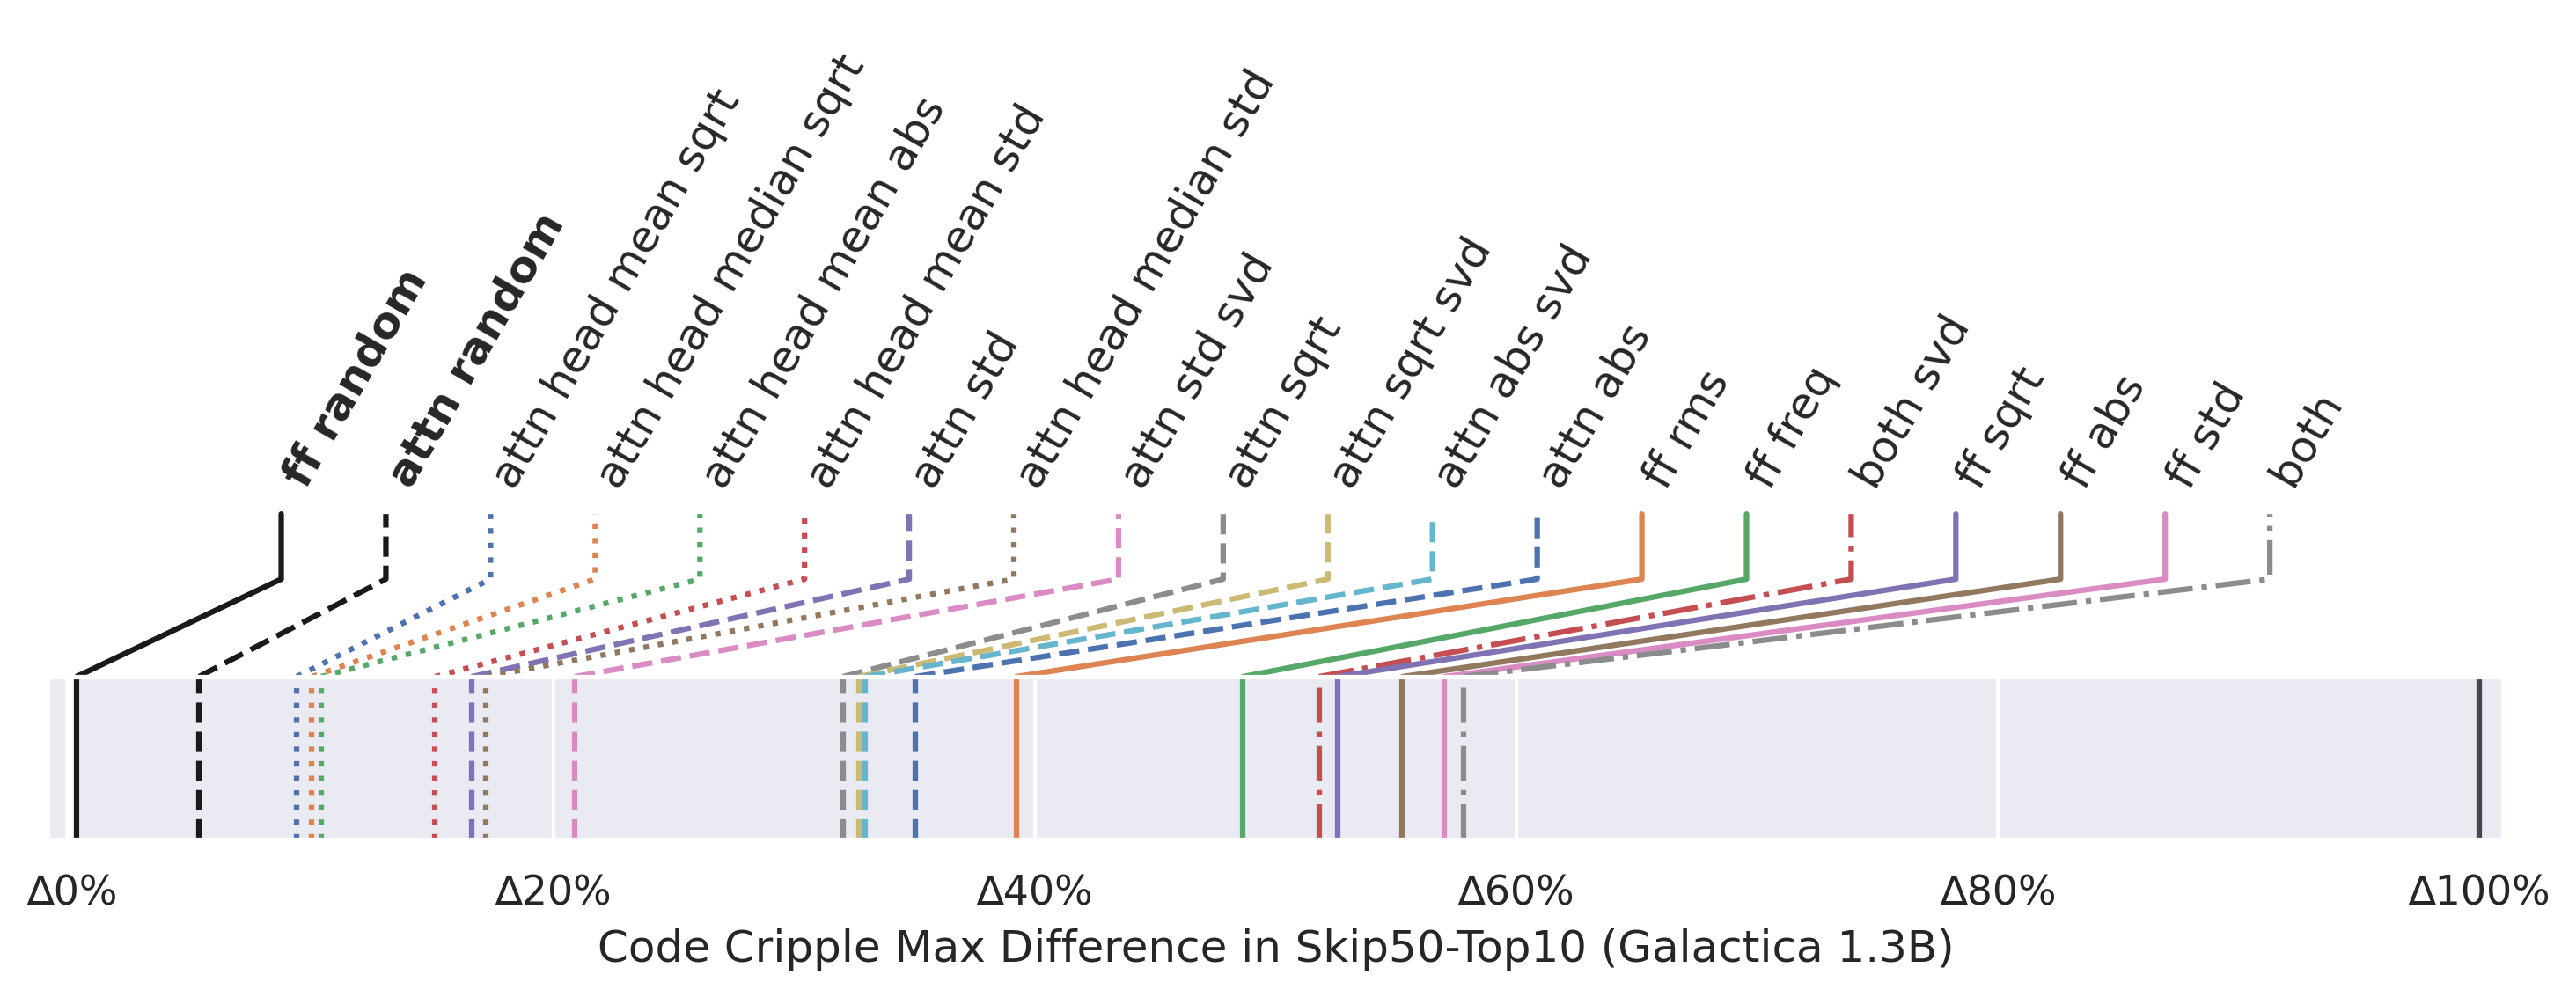

In [88]:
runs_filtered, run_limit = [], None
for run in _runs_attn:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "attn" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if "svd" in run.name and "attn h" in run.name:
        continue
    if not run.config["model_size"] == "facebook/galactica-1.3b":
        continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
            "gal 1.3b ff",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)

scale = 100
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_xlim(-0.01*scale, 1.01*scale)
ax2.set_xlim(-0.01*scale, 1.01*scale)
def percent_formatter(x, pos):
    return f'∆{x:.0f}%'
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
#ax2.text( 1, -0.55, "Code Cripple", ha="right", va="top")
ax2.set_xlabel("Code Cripple Max Difference in Skip50-Top10 (Galactica 1.3B)")

plt.show()

100


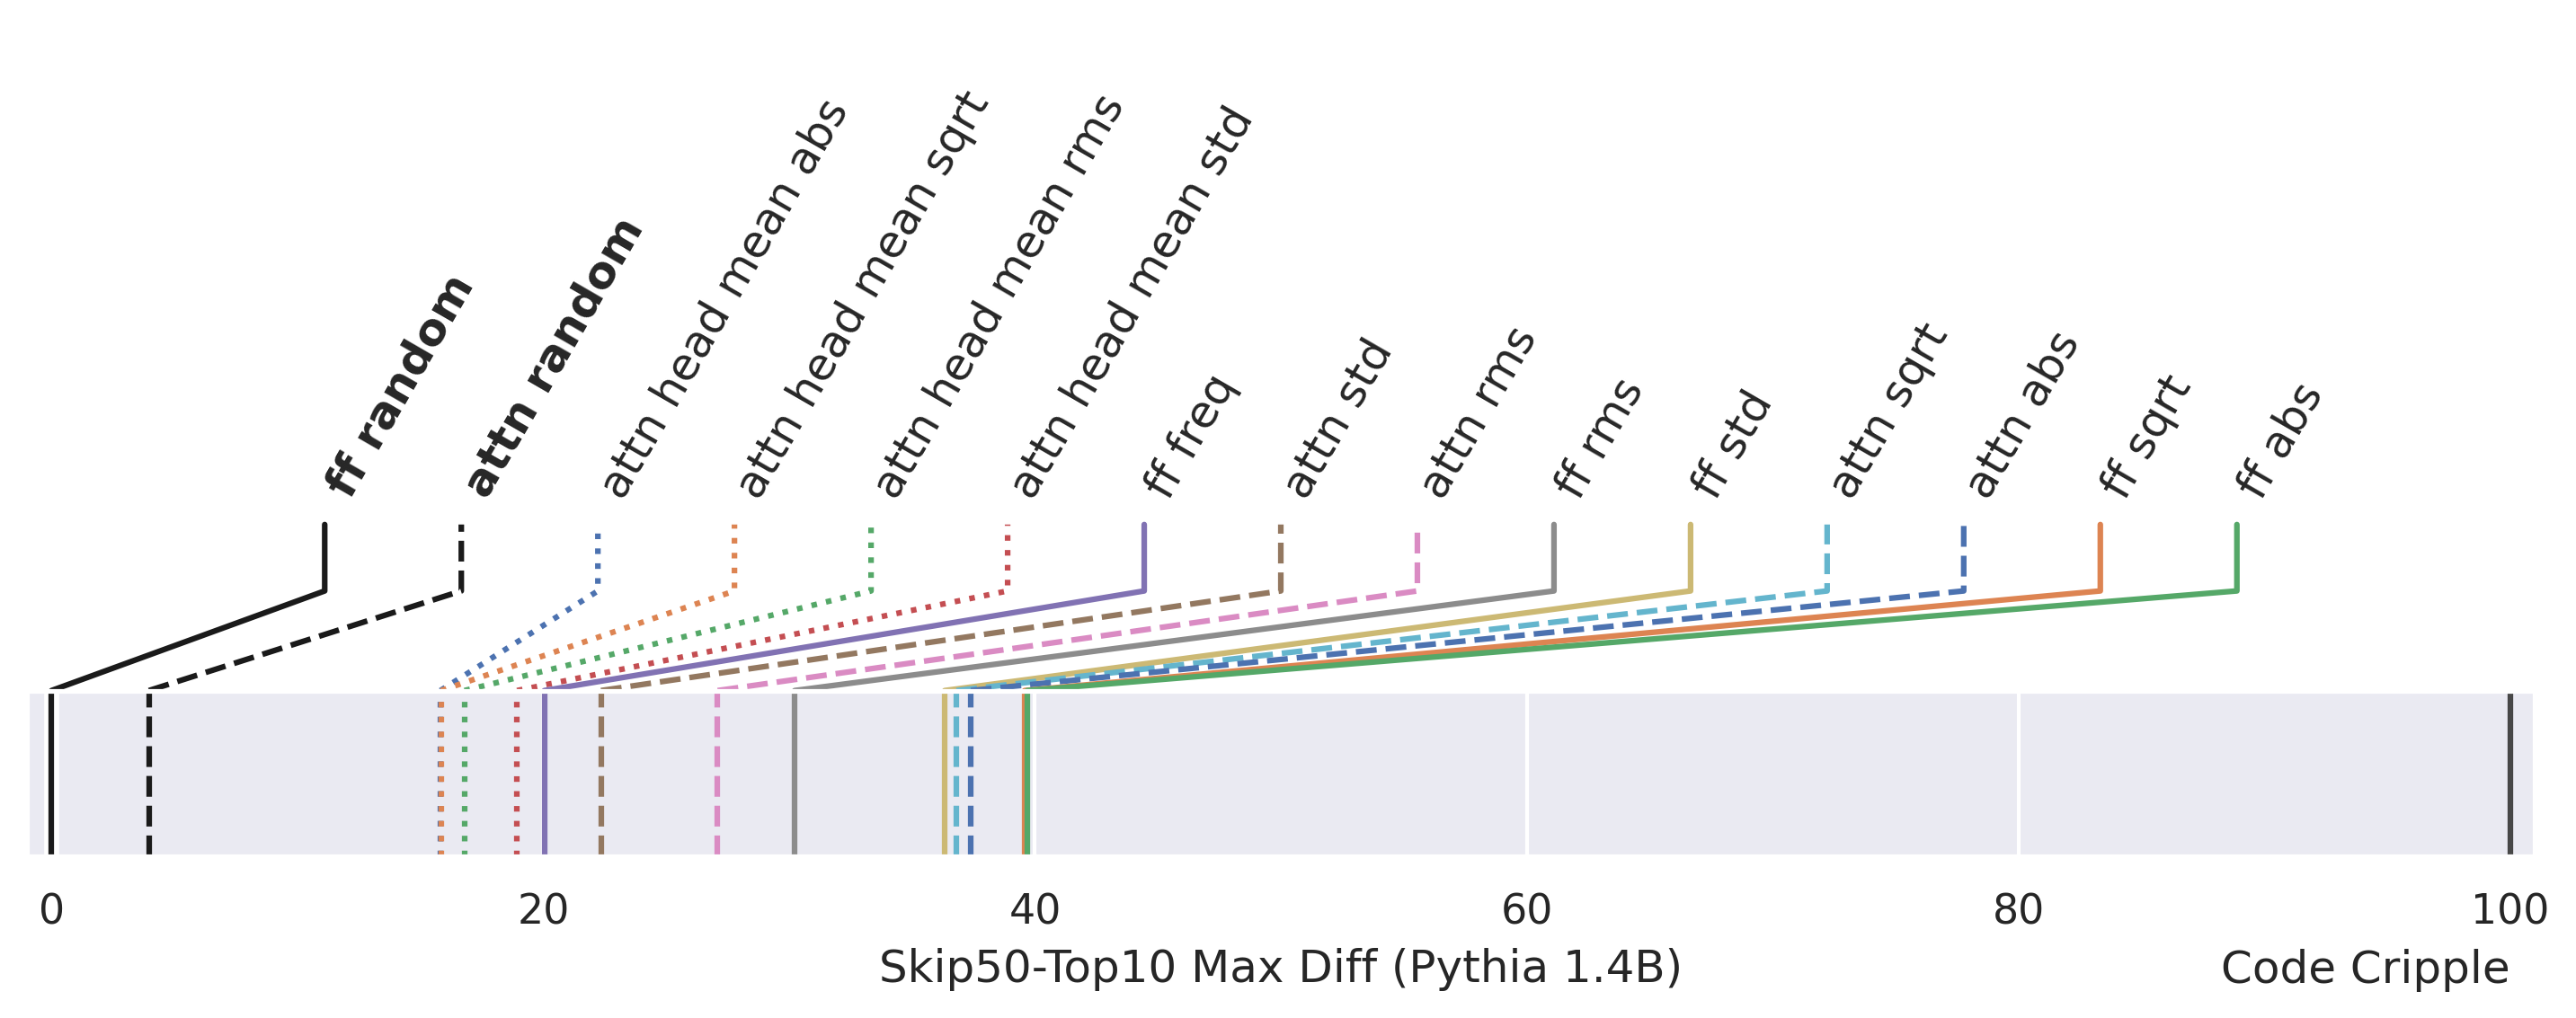

In [81]:
runs_filtered, run_limit = [], None
for run in _runs_attn:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    #if not "attn" in run.name:
    #    continue
    if "rev" in run.name:
        continue
    if "base" in run.name:
        continue
    if "attn v" in run.name:
        continue
    if not run.config["model_size"] == "EleutherAI/pythia-1.4B":
        continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)
   
scale = 100 
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_xlim(-0.01*scale, 1.01*scale)
ax2.set_xlim(-0.01*scale, 1.01*scale)
ax2.text( scale, -0.55, "Code Cripple", ha="right", va="top")
ax2.set_xlabel("Skip50-Top10 Max Diff (Pythia 1.4B)")
plt.show()

100


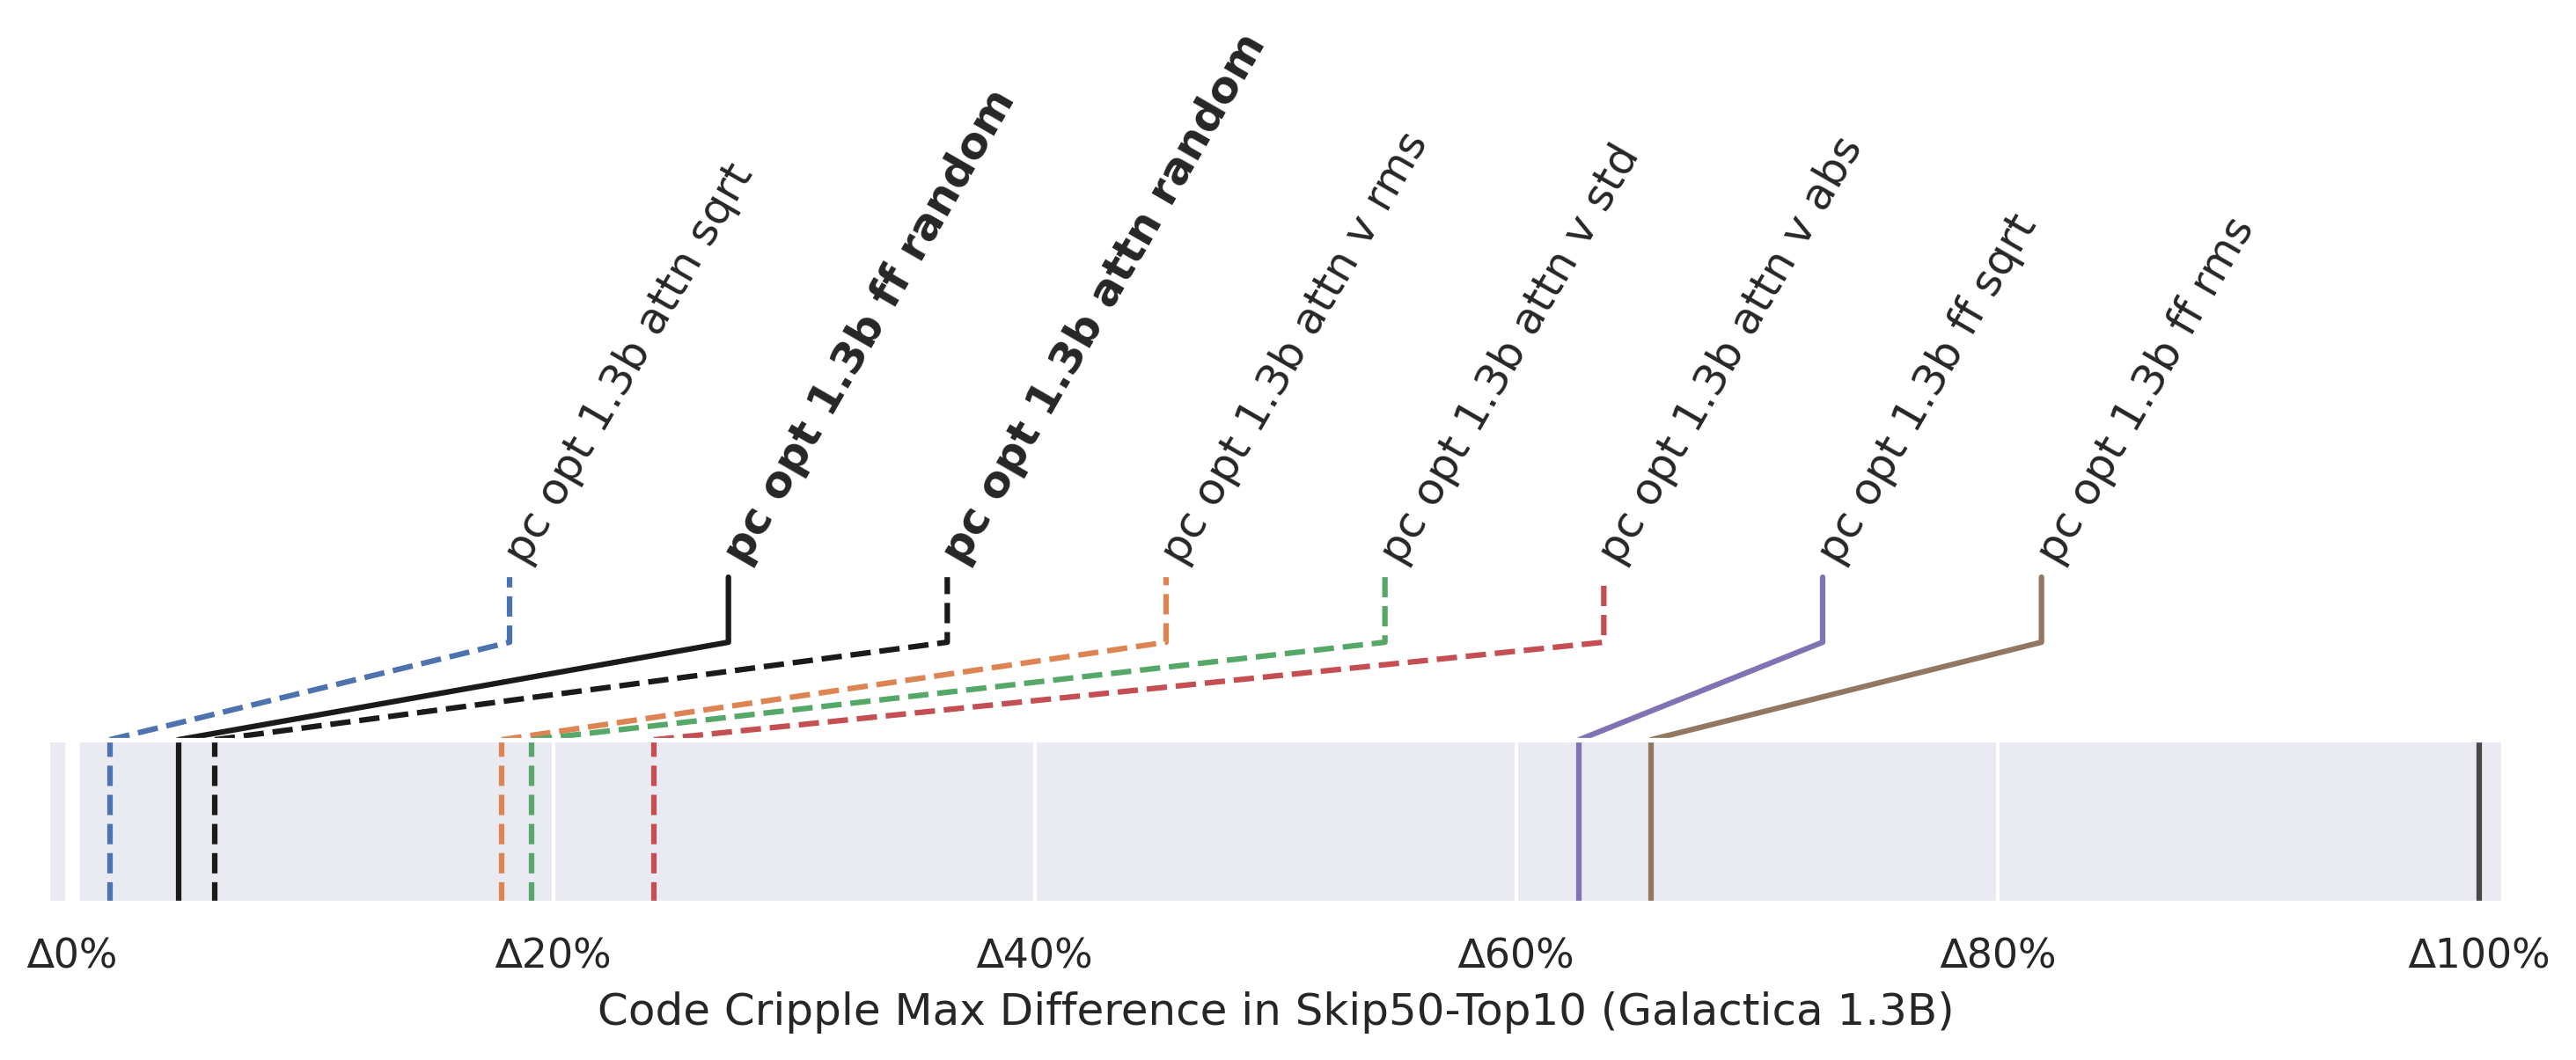

In [90]:

runs_filtered, run_limit = [], None
for run in _runs_attn:
    if run_limit and len(runs_filtered) > run_limit:
        break
    if run.state == "crashed":
        continue
    if not "_step" in run.summary or run.summary["_step"] < 1:
        continue
    if not "pc" in run.name:
        continue
    if "rev" in run.name:
        continue
    if "svd" in run.name and "attn h" in run.name:
        continue
    if not run.config["model_size"] == "facebook/opt-1.3b":
        continue
    if "L" in run.name:
        continue
    if run.name in [
            "gal 1.3b del bias attn abs",
            "gal 1.3b attn",
            "gal 1.3b both old",
            "gal 1.3b both svd-b",
            "gal 1.3b ff",
        ]:
        continue
    #print(run.name, run.config.items())
    runs_filtered.append(run.url)

scale = 100
fig, (ax1, ax2) = plot_technique_comparison(runs_filtered, scale)
ax1.set_xlim(-0.01*scale, 1.01*scale)
ax2.set_xlim(-0.01*scale, 1.01*scale)
def percent_formatter(x, pos):
    return f'∆{x:.0f}%'
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
#ax2.text( 1, -0.55, "Code Cripple", ha="right", va="top")
ax2.set_xlabel("Code Cripple Max Difference in Skip50-Top10 (Galactica 1.3B)")

plt.show()